<a href="https://colab.research.google.com/github/Mohamed-Khalil67/Project_SARS-COV-2/blob/main/SARS_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#hide
!pip install -Uqq fastbook
import fastbook

In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

In [7]:
path = Path('drive/MyDrive/SARS-COVID/')

In [8]:
path.ls()


(#2) [Path('drive/MyDrive/SARS-COVID/COVID'),Path('drive/MyDrive/SARS-COVID/non-COVID')]

In [9]:
(path/'COVID').ls()[0]


Path('drive/MyDrive/SARS-COVID/COVID/Covid (141).png')

In [10]:
(path/'non-COVID').ls()[0]


Path('drive/MyDrive/SARS-COVID/non-COVID/Non-Covid (30).png')

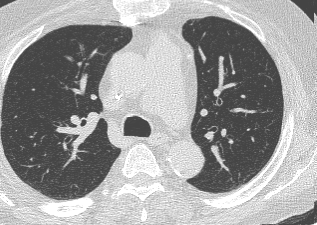

In [11]:
#looking into uploaded dataset images
import PIL

img1 = PIL.Image.open((path/'COVID').ls()[0])
img2 = PIL.Image.open((path/'non-COVID').ls()[0])

img1

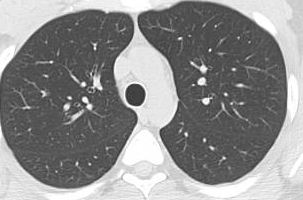

In [12]:
img2
